# **06 - Modelling and Evaluation - Predict Task Success**

## Objectives

* Fit and evaluate a classification model to predict if a developer will have task success.

## Inputs

* The Productivity_with_AI.csv file in 'outputs/datasets/collection/'
* Instructions on which variables to use feature engineering. They are found in each respective notebook. 

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

The notebooks are stored in a subfolder. Therefore when running the notebook in the editor, you will need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [64]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [65]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [66]:
current_dir = os.getcwd()
current_dir

'/'

# Load Data

In [67]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/Productivity_with_AI.csv"))

print(df.shape)
df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/collection/Productivity_with_AI.csv'

---

# ML pipeline for Data Cleaning and Feature Engineering

Since there is no data cleaning needed the function's name reflects that.

In [ ]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt


def PipelineFeatureEngineering():
    pipeline_base = Pipeline([
        ("NumericalTransformation", vt.PowerTransformer(variables=['ai_usage_hours'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('NumericalTransformation',
                 PowerTransformer(variables=['ai_usage_hours'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [ ]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

In [ ]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['task_success'], axis=1),
    df['task_success'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(400, 8) (400,) (100, 8) (100,)


## Handle Target Imbalance

Since there is no data cleaning needed the pipeline's name reflects that.

In [ ]:
pipeline_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_feat_eng.fit_transform(X_train)
X_test = pipeline_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(400, 5) (400,) (100, 5) (100,)


Check Train Set Target distribution

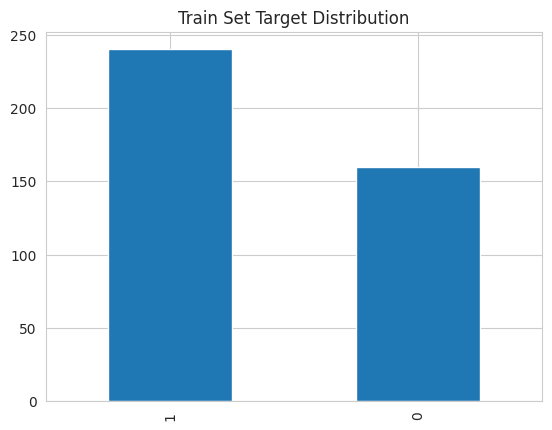

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(480, 5) (480,) (100, 5) (100,)


Check Train Set Target distribution after resampling

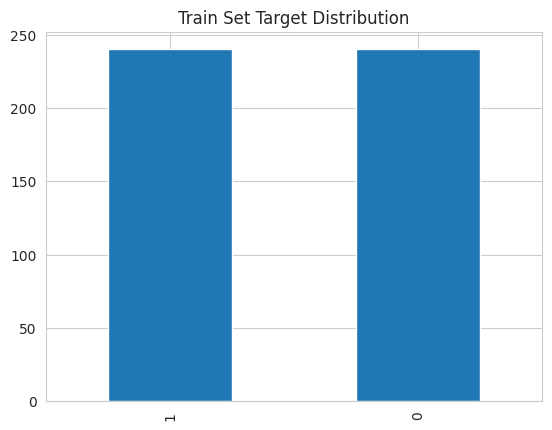

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [ ]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

In [ ]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


---

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
6,AdaBoostClassifier,0.833333,0.929167,0.979167,0.050346
4,GradientBoostingClassifier,0.8125,0.916667,1.0,0.061802
1,XGBClassifier,0.854167,0.9125,0.9375,0.030619
5,ExtraTreesClassifier,0.8125,0.895833,0.979167,0.054327
3,RandomForestClassifier,0.8125,0.891667,0.958333,0.053359
2,DecisionTreeClassifier,0.833333,0.883333,0.958333,0.046771
0,LogisticRegression,0.8125,0.866667,0.916667,0.042898


## Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [ ]:
models_search = {
    "AdaBoostClassifier":AdaBoostClassifier(
        estimator=DecisionTreeClassifier(),
        random_state=0
    ),
}

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "AdaBoostClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__estimator__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [ ]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__estimator__max_depth,model__learning_rate
2,AdaBoostClassifier,0.854167,0.9625,1.0,0.054962,3,0.001
1,AdaBoostClassifier,0.833333,0.916667,0.979167,0.051031,3,0.01
5,AdaBoostClassifier,0.833333,0.9,0.958333,0.044488,10,0.001
0,AdaBoostClassifier,0.791667,0.895833,0.979167,0.060381,3,0.1
8,AdaBoostClassifier,0.833333,0.891667,0.958333,0.054962,None,0.001
4,AdaBoostClassifier,0.8125,0.8875,0.916667,0.03864,10,0.01
6,AdaBoostClassifier,0.8125,0.8875,0.9375,0.042898,None,0.1
3,AdaBoostClassifier,0.8125,0.879167,0.916667,0.035843,10,0.1
7,AdaBoostClassifier,0.833333,0.879167,0.916667,0.030619,None,0.01


Get best model name programmatically

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__estimator__max_depth': 3, 'model__learning_rate': 0.001}

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                              random_state=0))),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.001, random_state=0))])

## Assess feature importance

In [ ]:
X_train.head()

,coffee_intake_mg,distractions,bugs_reported,ai_usage_hours,cognitive_load
0,473,5,0,1.067708,1.5
1,412,4,2,1.307670,4.3
2,600,2,1,0.761577,2.3
3,600,3,3,1.884144,5.2
4,600,1,0,0.547723,2.2


In [ ]:
len(X_train.columns)

5

* These are the 2 most important features in descending order. The model was trained on them: 
['coffee_intake_mg', 'cognitive_load']


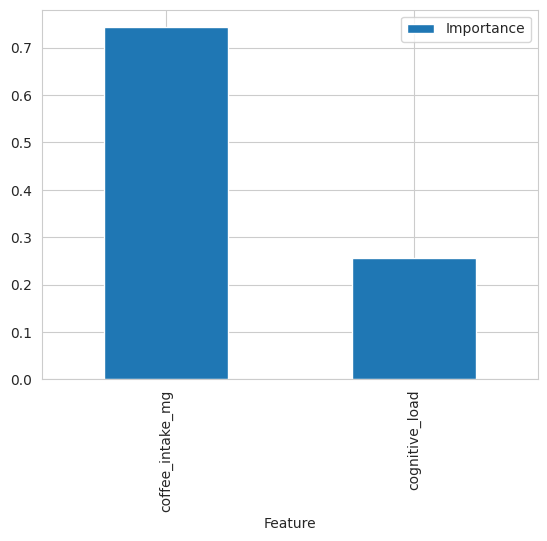

,Feature,Importance
0,coffee_intake_mg,0.742868
1,cognitive_load,0.257132


In [ ]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

df_feature_importance

## Evaluate Pipeline on Train and Test Sets

In [ ]:
#  This is code is from the scikit learn lesson to evaluate the classifiers
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case

* 80% Recall for no task success, on train and test set

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No task success', 'Task success'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                           Actual No task success Actual Task success
Prediction No task success                    208                   2
Prediction Task success                        32                 238


---  Classification Report  ---
                 precision    recall  f1-score   support

No task success       0.99      0.87      0.92       240
   Task success       0.88      0.99      0.93       240

       accuracy                           0.93       480
      macro avg       0.94      0.93      0.93       480
   weighted avg       0.94      0.93      0.93       480
 

#### Test Set ####

---  Confusion Matrix  ---
                           Actual No task success Actual Task success
Prediction No task success                     32                   1
Prediction Task success                         5                  62


---  Classification Report  ---
                 precision    recall  f1-score   support

No task suc

# Step 3: Refit pipeline with best features

## Rewrite ML pipeline for Feature Engineering

There will be no new pipeline for the following reasons:

* SmartCorrelatedSelection is already done: We have got the most important features
* We do not need to transform `ai_usage_hours` since it is not one of the most important features

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [ ]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['task_success'], axis=1),
    df['task_success'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(400, 8) (400,) (100, 8) (100,)


We filter only the most important variables

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(10)

(400, 2) (400,) (100, 2) (100,)


,coffee_intake_mg,cognitive_load
107,473,1.5
336,412,4.3
71,600,2.3
474,600,5.2
6,600,2.2
412,206,7.0
113,600,1.9
236,108,6.2
299,600,4.4
155,360,4.4


## Handle Target Imbalance

No DataCleaning is required since there is no missing data.

No FeatureEngineering is required for the train set since the 'best_features' do not include `ai_usage_hours`.

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(400, 2) (400,) (100, 2) (100,)


Check Train Set Target distribution

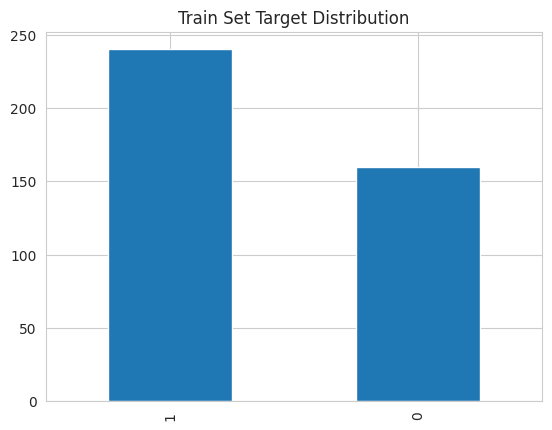

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(480, 2) (480,) (100, 2) (100,)


Check Train Set Target distribution after SMOTE

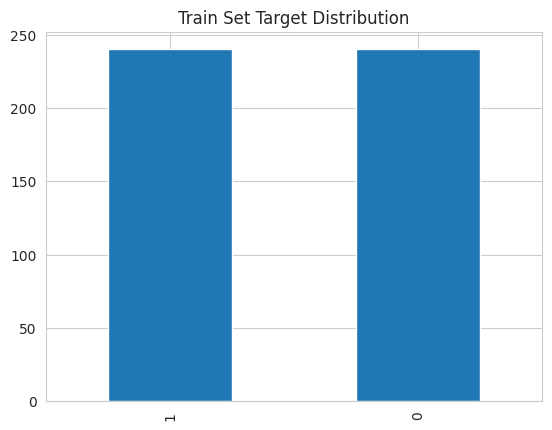

In [ ]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from the last GridCV search

In [ ]:
models_search   # AdaBoostClassifier

{'AdaBoostClassifier': AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=0)}

And the best parameters from the last GridCV search

In [ ]:
best_parameters

{'model__estimator__max_depth': 3, 'model__learning_rate': 0.001}

In [ ]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__estimator__max_depth': [3]},  # the value should be in []
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.01],
  'model__estimator__max_depth': [3]}}

GridSearch CV

In [ ]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__estimator__max_depth,model__learning_rate
0,AdaBoostClassifier,0.8125,0.908333,0.979167,0.058333,3,0.01


Define the best clf pipeline

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01, random_state=0))])

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['coffee_intake_mg', 'cognitive_load']


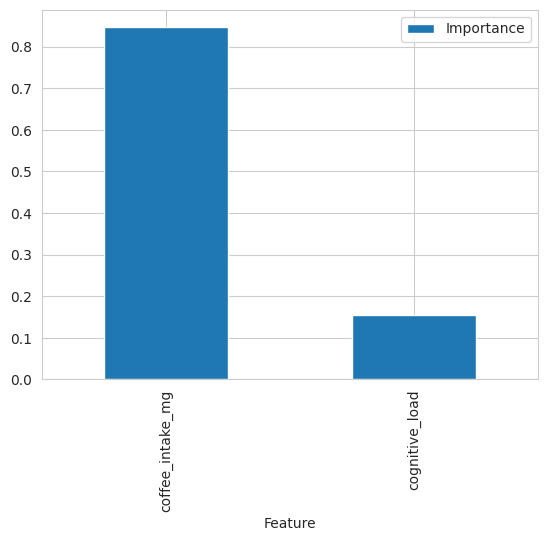

In [ ]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross check with metrics defined at ML business case

* 80% Recall for no task success, on train and test set

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No task success', 'Task success'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                           Actual No task success Actual Task success
Prediction No task success                    217                   6
Prediction Task success                        23                 234


---  Classification Report  ---
                 precision    recall  f1-score   support

No task success       0.97      0.90      0.94       240
   Task success       0.91      0.97      0.94       240

       accuracy                           0.94       480
      macro avg       0.94      0.94      0.94       480
   weighted avg       0.94      0.94      0.94       480
 

#### Test Set ####

---  Confusion Matrix  ---
                           Actual No task success Actual Task success
Prediction No task success                     35                   4
Prediction Task success                         2                  59


---  Classification Report  ---
                 precision    recall  f1-score   support

No task suc

# Step 4: Push files to Repo

We will generate the following files

* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_task_success/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_task_success/v1'


## Train Set

* Note that the variables in X_train don not require any transformation as already mentioned and the shape is 480 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

(480, 2)


,coffee_intake_mg,cognitive_load
0,473,1.5
1,412,4.3
2,600,2.3
3,600,5.2
4,600,2.2


In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

0      1
1      0
2      1
3      1
4      1
      ..
475    0
476    0
477    0
478    0
479    0
Name: task_success, Length: 480, dtype: int64

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* Note that the variables in X_test do not require any transformation as already mentioned.

In [ ]:
print(X_test.shape)
X_test.head()

(100, 2)


,coffee_intake_mg,cognitive_load
90,523,6.2
254,149,2.7
283,283,4.4
445,580,6.3
461,574,5.8


In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

90     1
254    0
283    0
445    1
461    1
      ..
372    1
56     0
440    1
60     1
208    1
Name: task_success, Length: 100, dtype: int64

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

* Pipeline responsible for Data Cleaning and Feature Engineering.

**THE PIPELINE BELOW HAS TO BE RENAMED SINCE THERE IS NO DATA CLEANING. SEE ABOVE FOR THE CORRECT NAME. OR MAYBE THE DATA CLEANING SHOULD BE LEFT IN THE TITLE**

In [ ]:

pipeline_feat_eng

Pipeline(steps=[('NumericalTransformation',
                 PowerTransformer(variables=['ai_usage_hours'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [ ]:
joblib.dump(value=pipeline_feat_eng ,
            filename=f"{file_path}/clf_pipeline_feat_eng.pkl")

['outputs/ml_pipeline/predict_task_success/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01, random_state=0))])

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_task_success/v1/clf_pipeline_model.pkl']

## Feature Importance plot

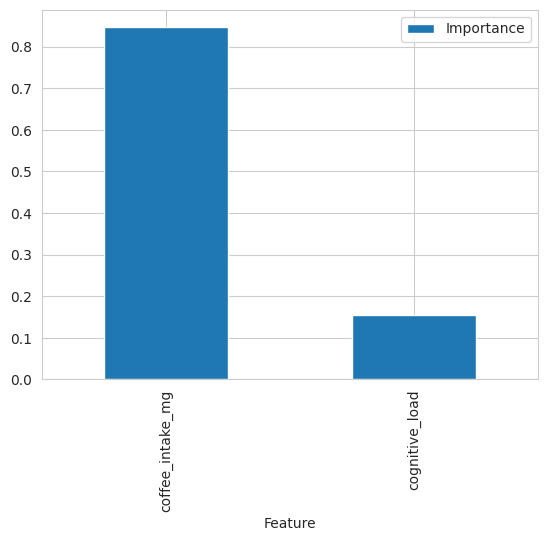

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

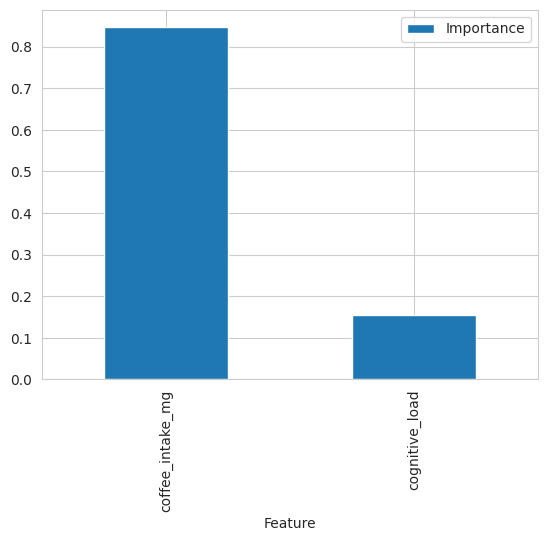

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')